In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from tqdm import tqdm

%matplotlib inline

## Loading Data

In [4]:
filepath = "auto.csv"
df = pd.read_csv(filepath, header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers
df.replace('?',np.NaN, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [6]:
df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [7]:
df.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [8]:
df.describe(include = "object")

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,bore,stroke,horsepower,peak-rpm,price
count,164,205,205,205,203,205,205,205,205,205,205,201,201,203,203,201
unique,51,22,2,2,2,5,3,2,7,7,8,38,36,59,23,186
top,161,toyota,gas,std,four,sedan,fwd,front,ohc,four,mpfi,3.62,3.40,68,5500,8921
freq,11,32,185,168,114,96,120,202,148,159,94,23,20,19,37,2


## Dealing with Missing Data

In [10]:
avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
df.replace({"normalized-losses": {np.nan: avg_norm_loss}}, inplace=True)

avg_bore=df['bore'].astype('float').mean(axis=0)
df.replace({"bore": {np.nan: avg_bore}}, inplace=True)

stroke_mean = df['stroke'].astype("float").mean(axis = 0)
df.replace({'stroke': {np.nan: stroke_mean}}, inplace = True)

avg_horsepower = df['horsepower'].astype('float').mean(axis=0)
df.replace({'horsepower': {np.nan: avg_horsepower}}, inplace=True)

avg_peakrpm=df['peak-rpm'].astype('float').mean(axis=0)
df.replace({'peak-rpm':{np.nan: avg_peakrpm}}, inplace=True)

most_feq = df['num-of-doors'].value_counts().idxmax()
df.replace({"num-of-doors" : {np.nan: "four"}}, inplace=True)

df.dropna(subset=["price"], axis=0, inplace = True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized-losses  201 non-null    object 
 2   make               201 non-null    object 
 3   fuel-type          201 non-null    object 
 4   aspiration         201 non-null    object 
 5   num-of-doors       201 non-null    object 
 6   body-style         201 non-null    object 
 7   drive-wheels       201 non-null    object 
 8   engine-location    201 non-null    object 
 9   wheel-base         201 non-null    float64
 10  length             201 non-null    float64
 11  width              201 non-null    float64
 12  height             201 non-null    float64
 13  curb-weight        201 non-null    int64  
 14  engine-type        201 non-null    object 
 15  num-of-cylinders   201 non-null    object 
 16  engine-size        201 non

In [11]:
df[["bore", "stroke", "normalized-losses", "price", "peak-rpm", "horsepower"]] = df[["bore", "stroke", "normalized-losses", "price", "peak-rpm", "horsepower"]].astype("float")
df[["bore", "stroke", "normalized-losses", "price", "peak-rpm", "horsepower"]].dtypes

bore                 float64
stroke               float64
normalized-losses    float64
price                float64
peak-rpm             float64
horsepower           float64
dtype: object

## Standardization & Normalization

In [13]:
df[['city-mpg', 'highway-mpg']] = 235/df[['city-mpg', 'highway-mpg']]
df.rename(columns = {"city-mpg": "city-L/100km", "highway-mpg": "highway-L/100km"}, inplace = True)
df['length'] = df['length']/df['length'].max()
df['width'] = df['width']/df['width'].max()
df["height"] = df["height"] / df["height"].max()
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,11.190476,8.703704,13495.0
1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,11.190476,8.703704,16500.0
2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,12.368421,9.038462,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,9.791667,7.833333,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,13.055556,10.681818,17450.0


## Data Binning

Text(0.5, 1.0, 'Horsepower Bins')

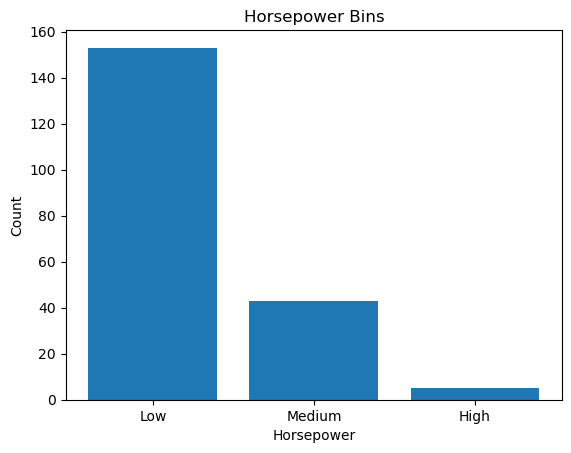

In [110]:
bins = np.linspace(min(df["horsepower"]), max(df["horsepower"]), 4)
names = ['Low', 'Medium', 'High']
df['horsepower-binned'] = pd.cut(df['horsepower'], bins, labels=names, include_lowest=True )
df[["horsepower-binned"]] = df[["horsepower-binned"]].astype("object")
plt.bar(names, df["horsepower-binned"].value_counts())

# set x/y labels and plot title
plt.xlabel("Horsepower")
plt.ylabel("Count")
plt.title("Horsepower Bins")

Text(0.5, 1.0, 'Engine Size Bins')

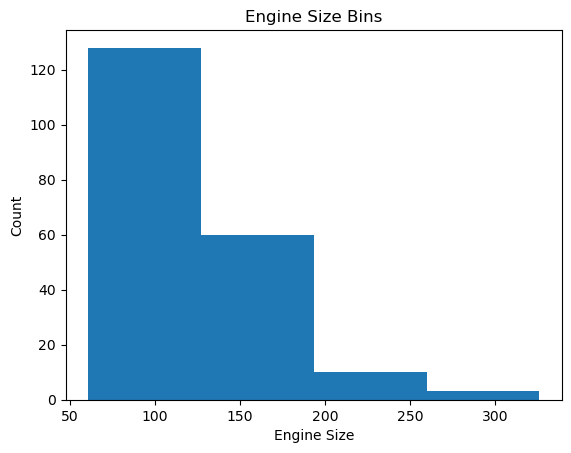

In [112]:
plt.hist(df["engine-size"], bins = 4)

# set x/y labels and plot title
plt.xlabel("Engine Size")
plt.ylabel("Count")
plt.title("Engine Size Bins")

## Dummy Variables

In [18]:
dummy_1 = pd.get_dummies(df["fuel-type"])
dummy_1.rename(columns={'gas':'fuel-gas', 'diesel':'fuel-diesel'}, inplace=True)
df = pd.concat([df, dummy_1], axis=1)
df[["fuel-diesel", "fuel-gas"]] = df[["fuel-diesel", "fuel-gas"]].astype("int64")
df.drop(["fuel-type"], axis = 1, inplace=True)
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,stroke,compression-ratio,horsepower,peak-rpm,city-L/100km,highway-L/100km,price,horsepower-binned,fuel-diesel,fuel-gas
0,3,122.0,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,2.68,9.0,111.0,5000.0,11.190476,8.703704,13495.0,Low,0,1
1,3,122.0,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,2.68,9.0,111.0,5000.0,11.190476,8.703704,16500.0,Low,0,1
2,1,122.0,alfa-romero,std,two,hatchback,rwd,front,94.5,0.822681,...,3.47,9.0,154.0,5000.0,12.368421,9.038462,16500.0,Medium,0,1
3,2,164.0,audi,std,four,sedan,fwd,front,99.8,0.848630,...,3.40,10.0,102.0,5500.0,9.791667,7.833333,13950.0,Low,0,1
4,2,164.0,audi,std,four,sedan,4wd,front,99.4,0.848630,...,3.40,8.0,115.0,5500.0,13.055556,10.681818,17450.0,Low,0,1


In [19]:
## Check the

In [20]:
nucolumns = df.select_dtypes(include=['number']).columns.values.tolist()
df[nucolumns].corr()["price"].sort_values()

fuel-gas            -0.110326
peak-rpm            -0.101616
symboling           -0.082391
compression-ratio    0.071107
stroke               0.082269
fuel-diesel          0.110326
normalized-losses    0.133999
height               0.135486
bore                 0.543155
wheel-base           0.584642
length               0.690628
width                0.751265
city-L/100km         0.789898
highway-L/100km      0.801118
horsepower           0.809575
curb-weight          0.834415
engine-size          0.872335
price                1.000000
Name: price, dtype: float64

(0.0, 53080.26624186304)

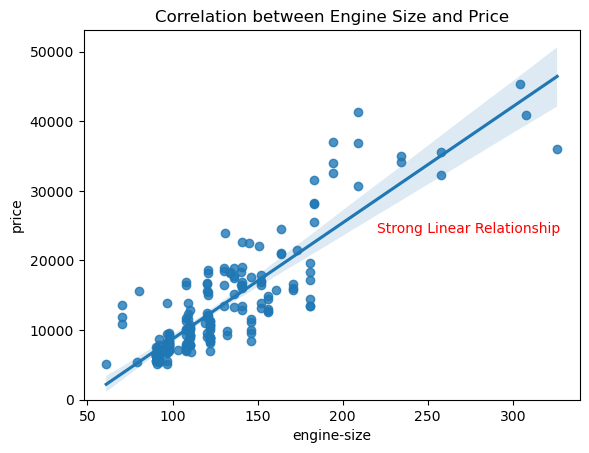

In [114]:
sns.regplot(x="engine-size", y="price", data=df)
plt.title("Correlation between Engine Size and Price")
plt.text(220, 24000, "Strong Linear Relationship", color="red")
plt.ylim(0,)

(0.0, 47716.08075606736)

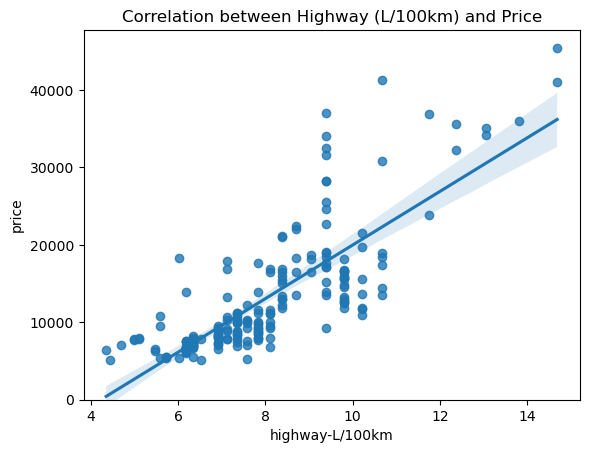

In [22]:
sns.regplot(x="highway-L/100km", y="price", data=df)
plt.title("Correlation between Highway (L/100km) and Price")
plt.ylim(0,)

(0.0, 47414.1)

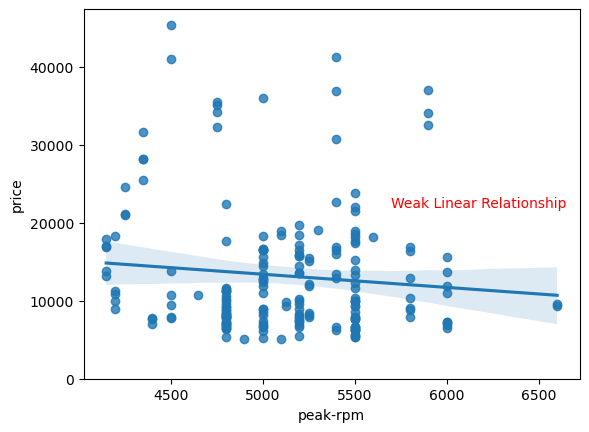

In [23]:
sns.regplot(x="peak-rpm", y="price", data=df)
plt.text(5700,22000, "Weak Linear Relationship", color="red")
plt.ylim(0,)

Text(0, 45000, 'Weak Categorical Relationship')

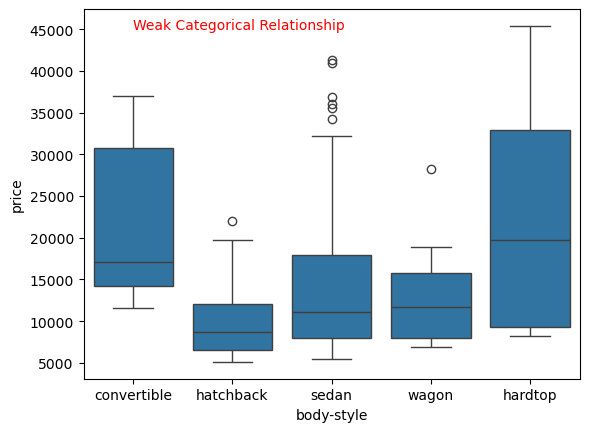

In [118]:
sns.boxplot(x="body-style", y="price", data=df)
plt.text(0, 45000, "Weak Categorical Relationship", color="red")

Text(0.5, 25000, 'Strong Categorical Relationship')

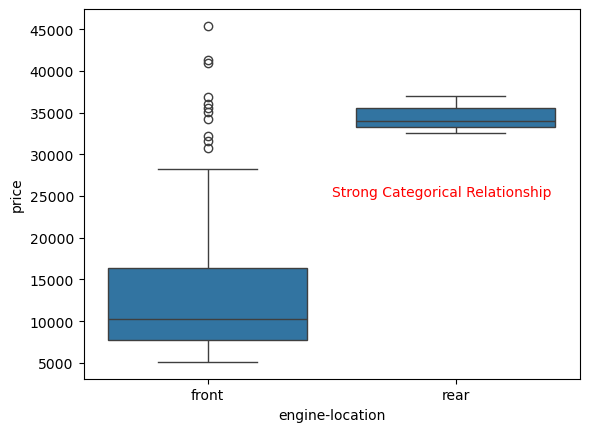

In [122]:
sns.boxplot(x="engine-location", y="price", data=df)
plt.text(0.5, 25000, "Strong Categorical Relationship", color="red")

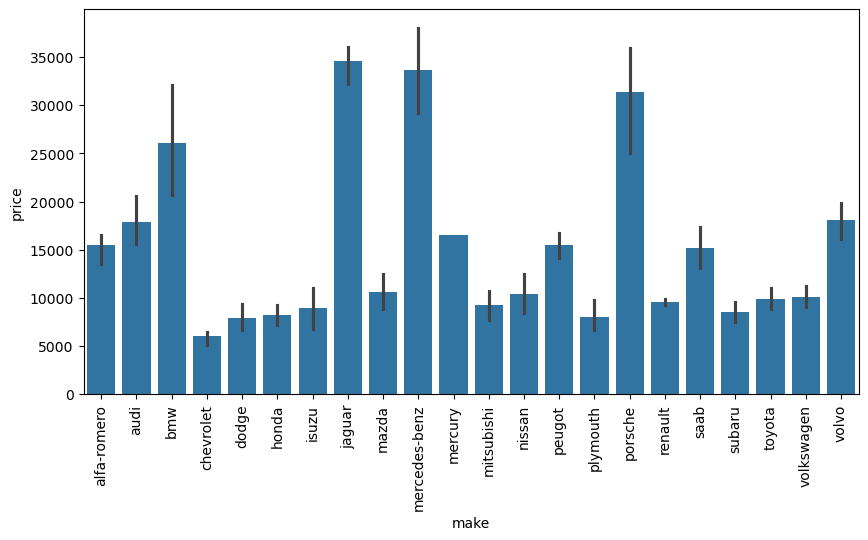

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(x="make", y="price", data=df)
plt.xticks(rotation=90)
plt.show()

In [27]:
df_gptest = df[['drive-wheels','body-style','price']]
df_3v = df_gptest.groupby(['drive-wheels','body-style'],as_index=False).mean()
df_pivot = df_3v.pivot(index='drive-wheels',columns='body-style').fillna(0)
df_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  0.0      0.000000   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

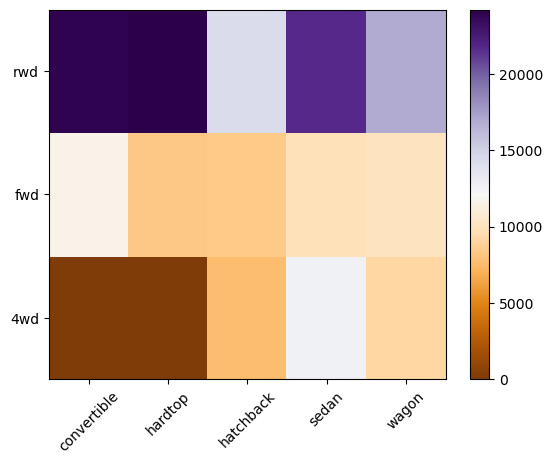

In [29]:
plt.pcolor(df_pivot, cmap="PuOr")

row_labels = df_pivot.columns.levels[1]
col_labels = df_pivot.index
plt.xticks(np.arange(df_pivot.shape[1]) + 0.5, row_labels, minor=False, rotation=45)
plt.yticks(np.arange(df_pivot.shape[0]) + 0.5, col_labels, minor=False)

plt.colorbar()

In [30]:
li = ['horsepower', 'length', 'width', 'curb-weight', 'engine-size', 'bore', 'city-L/100km', 'highway-L/100km', 'wheel-base']
for i in li:
    c, p = stats.pearsonr(df[i], df['price'])
    print(f"{i.capitalize()}\nPearson Coefficient:{c.round(4)}\nP-value:{p}\n")

Horsepower
Pearson Coefficient:0.8096
P-value:6.369057428259557e-48

Length
Pearson Coefficient:0.6906
P-value:8.01647746615924e-30

Width
Pearson Coefficient:0.7513
P-value:9.20033551048206e-38

Curb-weight
Pearson Coefficient:0.8344
P-value:2.189577238893965e-53

Engine-size
Pearson Coefficient:0.8723
P-value:9.265491622198793e-64

Bore
Pearson Coefficient:0.5432
P-value:8.049189483935315e-17

City-l/100km
Pearson Coefficient:0.7899
P-value:3.9031064009394357e-44

Highway-l/100km
Pearson Coefficient:0.8011
P-value:3.0467845810414008e-46

Wheel-base
Pearson Coefficient:0.5846
P-value:8.076488270732885e-20



In [31]:
lm = LinearRegression()
X = df[['highway-L/100km']]
Y = df['price']
lm.fit(X,Y)
Yhat=lm.predict(X)
lm.score(X, Y), mean_squared_error(Y, Yhat)

(0.6417894513258818, 22510543.777085222)

Text(4.5, -5000, 'Non-linearity')

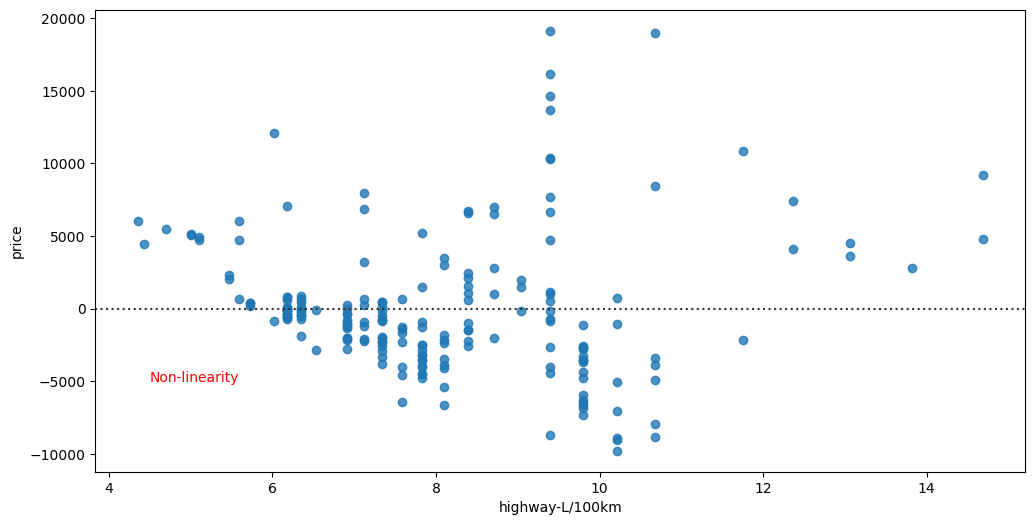

In [126]:
plt.figure(figsize=(12, 6))
sns.residplot(x=X, y=Y)
plt.text(4.5, -5000, "Non-linearity", color="red")

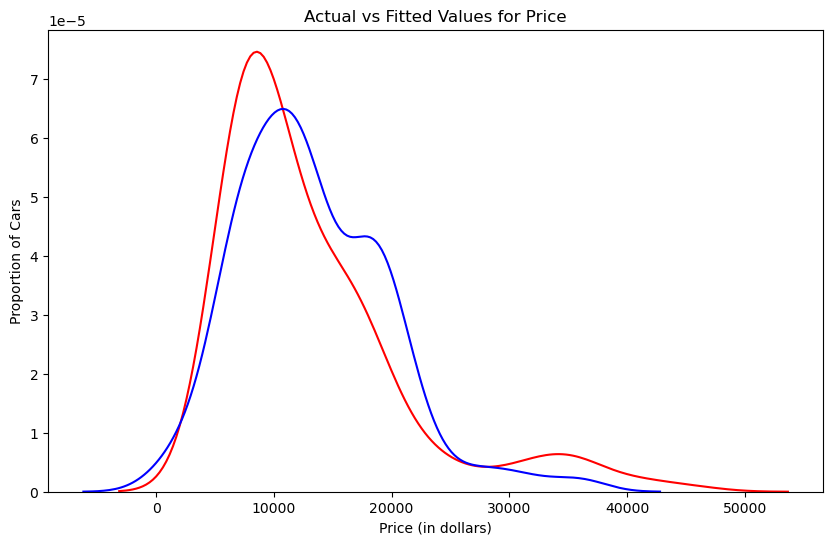

In [33]:
plt.figure(figsize=(10, 6))
ax1 = sns.kdeplot(Y, color="r", label="Actual Value")
sns.kdeplot(Yhat, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')
plt.show()


In [34]:
Z = df[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']]
lm.fit(Z, Y)
YhatZ = lm.predict(Z)
lm.score(Z, Y), mean_squared_error(Y, YhatZ)

(0.8118005191488038, 11826766.878324661)

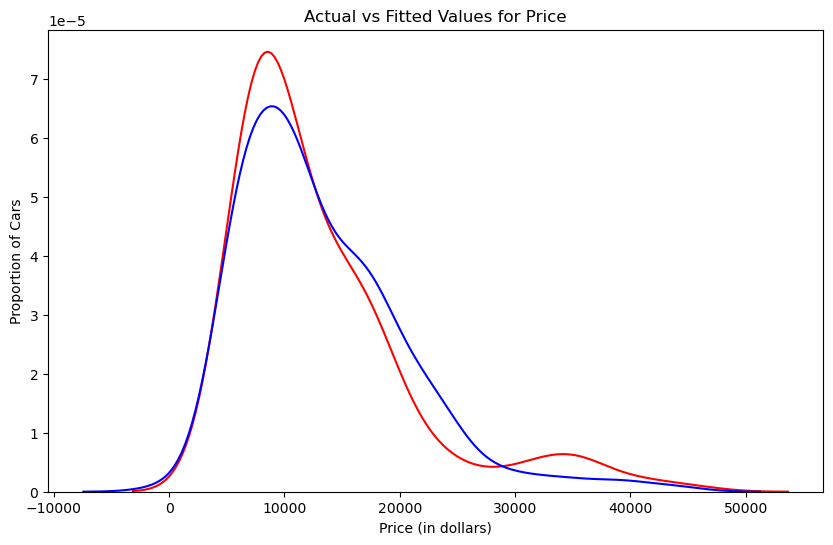

In [35]:
plt.figure(figsize=(10, 6))
ax1 = sns.kdeplot(Y, color="r", label="Actual Value")
sns.kdeplot(YhatZ, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price (in dollars)')
plt.ylabel('Proportion of Cars')
plt.show()

In [36]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(4, 15, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Price ~ Length')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Price of Cars')

    plt.show()
    plt.close()

In [37]:
x = df['highway-L/100km']
f = np.polyfit(x, Y, 3)
p = np.poly1d(f)
r2_score(Y, p(x)), mean_squared_error(Y, p(x))

(0.6753581660812172, 20401030.180019394)

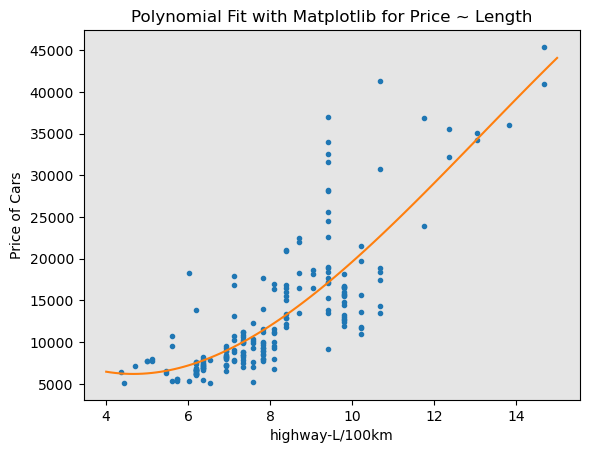

In [38]:
PlotPolly(p, x, Y, 'highway-L/100km')

In [39]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
Z = Z.astype(float)
pipe.fit(Z,Y)
Ypipe=pipe.predict(Z)
r2_score(Y, Ypipe), mean_squared_error(Y, Ypipe)

(0.8530915816872606, 9231968.164789582)

Text(25000, 3e-05, 'Perfectly Fitted')

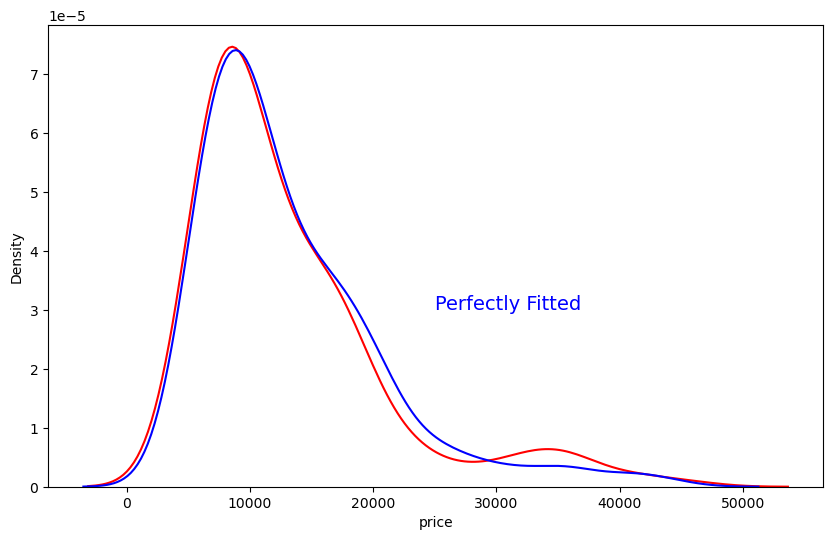

In [136]:
plt.figure(figsize=(10, 6))
ax1 = sns.kdeplot(Y, color="r", label="Actual Value")
sns.kdeplot(Ypipe, color="b", label="Fitted Values" , ax=ax1)
plt.text(25000, 0.00003, "Perfectly Fitted", color="blue", fontsize=14)

In [41]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    plt.show()
    plt.close()

In [150]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 10
    height = 8
    plt.figure(figsize=(width, height))
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
    xmax=max([xtrain.values.max(), xtest.values.max()])
    xmin=min([xtrain.values.min(), xtest.values.min()])
    x=np.arange(xmin, xmax, 0.1)

    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## cross_val_score

In [47]:
Rcross = cross_val_score(lm, X_data[['horsepower']], Y_data, cv=4)
print("R Squared\nmean:", Rcross.mean(), "\nstd:" , Rcross.std(), "\n")
mse = -1 * cross_val_score(lm,X_data[['horsepower']], Y_data,cv=4,scoring='neg_mean_squared_error')
print("MSE\nmean:", mse.mean())

Yhat = cross_val_predict(lm, X_data[['horsepower']], Y_data, cv=4)

R Squared
mean: 0.522009915042119 
std: 0.2911839444756029 

MSE
mean: 23525298.54198599


## train_test_split

In [44]:
df_num=df._get_numeric_data()
Y_data = df_num["price"]
X_data=df_num.drop('price',axis=1) 
lm = LinearRegression()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.10, random_state=1)
lm.fit(x_train[['horsepower']], y_train)
lm.score(x_test[['horsepower']], y_test), lm.score(x_train[['horsepower']], y_train)

(0.3635875575078824, 0.6619724197515103)

In [46]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_data, Y_data, test_size = 0.4, random_state = 0)
lm.fit(x_train1[['horsepower']], y_train1)
lm.score(x_test1[['horsepower']], y_test1), lm.score(x_train1[['horsepower']], y_train1)

(0.7139364665406973, 0.5754067463583004)

## Overfitting

In [146]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.45, random_state=0)

pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
Lm = LinearRegression()
lm.fit(x_train_pr, y_train)
Yhat = lm.predict(x_test_pr)
lm.score(x_test_pr, y_test)

-29.8718117882828

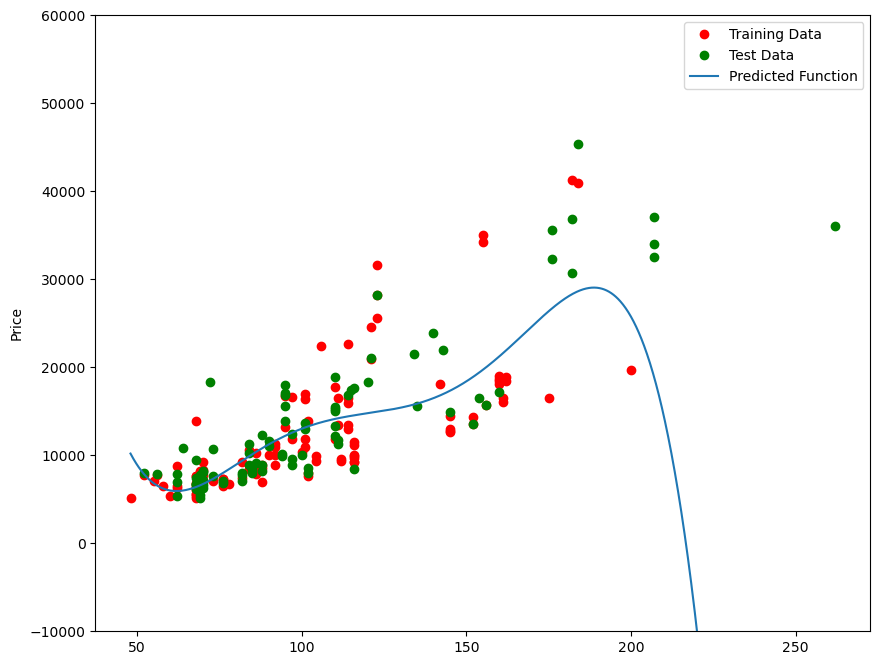

In [152]:
PollyPlot(x_train['horsepower'], x_test['horsepower'], y_train, y_test, lm, pr)

## Finding Best Order to Avoid Overfitting

[0.7325101750243117, 0.7405858710699887, 0.7406204232771993, 0.4063966369873978]


Text(3.2, 0.73, 'Maximum R^2 ')

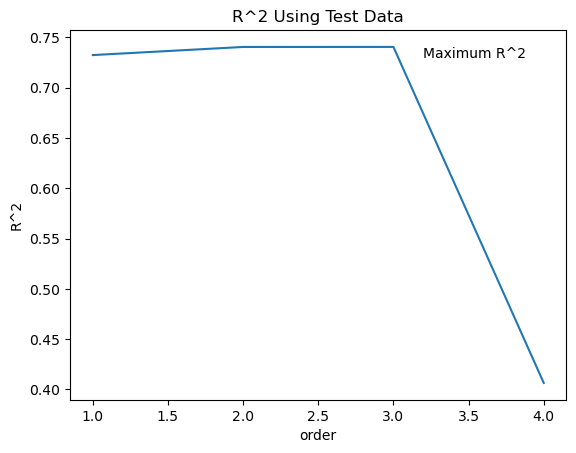

In [52]:
Rsqu_test = []
order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    lm.fit(x_train_pr, y_train)
    Rsqu_test.append(lm.score(x_test_pr, y_test))
    
print(Rsqu_test)
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3.2, 0.73, 'Maximum R^2 ')    

## Finding the Best Alpha

In [175]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km','normalized-losses','symboling']])

In [177]:
Rsqu_test = []
Rsqu_train = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)


100%|██████████| 1000/1000 [00:04<00:00, 217.58it/s, Test Score=0.673, Train Score=0.86]


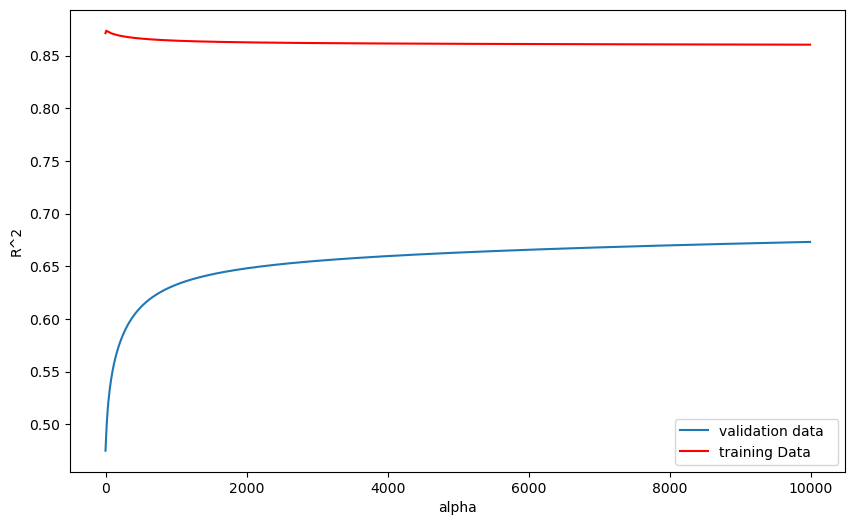

In [179]:
plt.figure(figsize=(10, 6))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

## Using GridSearchCV for Finding Best Model and Parameter

In [56]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
RR = Ridge()
Grid1 = GridSearchCV(RR, parameters1, cv=4)
Grid1.fit(X_data[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], Y_data)
BestRR=Grid1.best_estimator_
best_alpha = Grid1.best_params_['alpha']
BestRR

Ridge(alpha=10000)

In [57]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_test),\
BestRR.score(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-L/100km']], y_train)

(0.8411379151451636, 0.7679009564679338)

In [185]:
best_alpha

10000